# Week 2 Lecture 2 - Geocentric models and wiggly orbits

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An R/Stan repo of code is available here: https://vincentarelbundock.github.io/rethinking2/

An excellent port to Python/PyMC Code is available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import random as rd
import pymc as pm
import patsy
from matplotlib import pyplot as plt

## !Kung Kids

Let's import the Nancy Howell's data from the Kalahari people and take a look:

In [2]:
# Import data
kdata = pd.read_csv('..\data\howell.csv')
# Display top 5 rows
kdata.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
# Table of descriptive statistics
kdata.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


Let's take a look at the distribution of the data

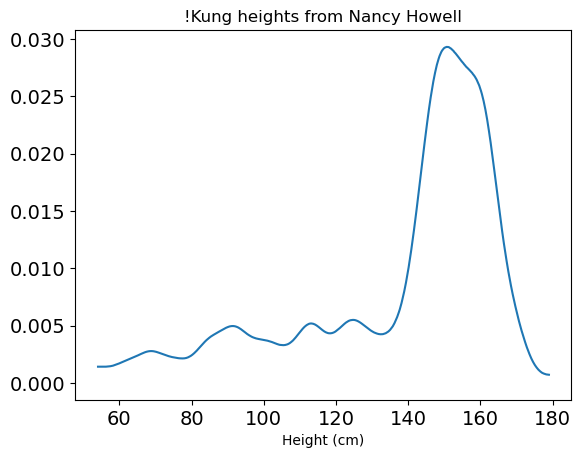

In [4]:
# Use pymc plotting features to plot the distribution of adult heights
pm.plot_kde(kdata.height.values)
plt.xlabel('Height (cm)')
plt.title('!Kung heights from Nancy Howell')
plt.savefig('fullkung.jpg', dpi=300);

Long tails here, what's going on?

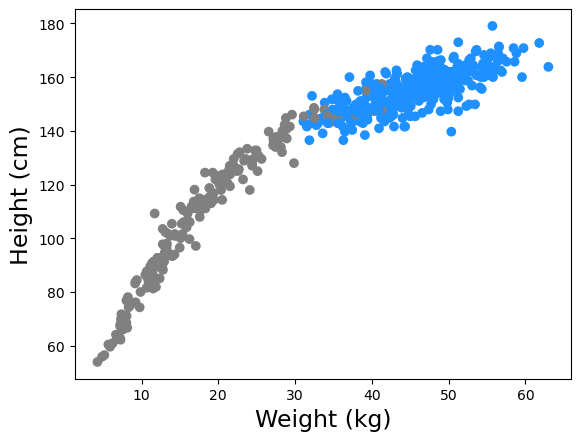

In [5]:
# Colours for kids
xcol = np.array(['grey','dodgerblue'])
# Dummy for kids
Ik = (kdata.age>17)*1
plt.scatter(kdata.weight, kdata.height, c=xcol[Ik])
plt.xlabel('Weight (kg)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('heightweight.jpg', dpi=300);

Ah, those pesky kids. So our glorious linearity among the adults is now gone. So how should we model this relationship?


# Curves from 'linear models'

### Link functions
    - common
    - ok

### Polyomial regression
    - common
    - bad

### Splines
    - very flexible
    - highly geocentric



## Link functions

Link functions are present in every statistical model as they translate the model scale - which can be log-odds for example - onto the observation scale. A log-link or logit-link are common choices. Let's see what a log link does to our plot:

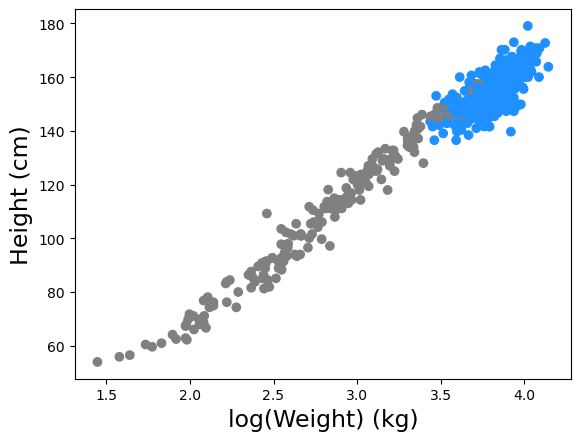

In [6]:
# Colours for kids
xcol = np.array(['grey','dodgerblue'])
# Dummy for kids
Ik = (kdata.age>17)*1
plt.scatter(np.log(kdata.weight), kdata.height, c=xcol[Ik])
plt.xlabel('log(Weight) (kg)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('logheightweight.jpg', dpi=300);

Near linearity - very helpful.

## Polynomial Regression

If you care not about any sort of process but are confident in the relative shape of what you want, a polynomial can **sometimes** be worth a look. 

$1^{st}$ order (line): $\mu_i = \beta_0+\beta_1 x_i$

$2^{nd}$ order (parabola): $\mu_i = \beta_0+\beta_1 x_i+\beta_2 x^{2}_i$

$3^{rd}$ order (cubic): $\mu_i = \beta_0+\beta_1 x_i+\beta_2 x^{2}_i+\beta_3 x^{3}_i$

$n^{th}$ order (insanity): $\mu_i = \beta_0+\beta_1 x_i+\beta_2 x^{2}_i+...+\beta_n x^{n}_i$

And it goes on...with increasingly uninterpretable results. Even the parabolic parameters are not individually interpretable, so be careful!!


## Polynomial !Kungs

So let's try fitting a paraboloa and see how well it does. As a first step we're going to standardize the data, meaning we'll subtract the mean (as always) and also divide by the standard deviation*. Why? Because it makes the intercept interpretable (as with zero-centreing) and because it places things on a small-ish scale near zero, where likelhoods don't explode. 

\*Note I typically standardize by 2sd because it makes 0-1 (dummy) variables comparable with standardized variables, allowing us to look at **relative** effect sizes

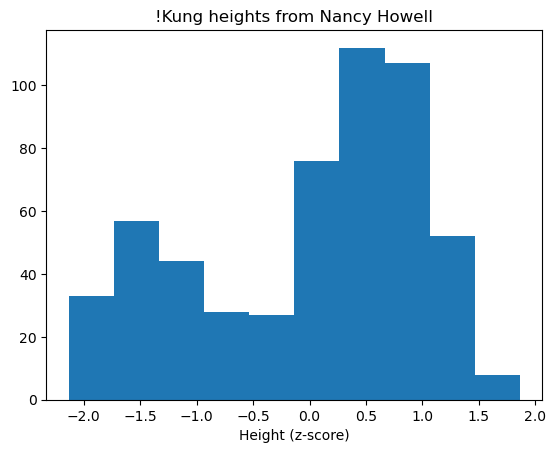

In [7]:
# Standardize weights
kweights = (kdata.weight.values-np.mean(kdata.weight.values))/np.std(kdata.weight.values)
plt.hist(kweights)
plt.xlabel('Height (z-score)')
plt.title('!Kung heights from Nancy Howell')
plt.savefig('zkung.jpg', dpi=300);

So for our model:

$$
\large{
\begin{align*}
z_i &= \frac{x_i-\bar{x}}{SD(x)} \\
h_i &\sim N(\mu_i,\sigma) \\
\mu_i &= \beta_0 + \beta_1z_i + \beta_2z^{2}_i \\
\beta_0 &\sim N(178,20) \\
\beta_1 &\sim logN(0,1) \\
\beta_2 &\sim N(0,1) \\
\sigma &\sim U(0, 50)
\end{align*}}
$$

We've added the quadratic parameter $\beta_2$, for which we have specified a $N(0,1)$ prior. Why? Weelll based on the recommendations of our modern-day Bayesian Yoda [Andrew Gelman](http://www.stat.columbia.edu/~gelman/), who very often standardizes covariates and uses $N(0,1)$ priors in his own work. He's done the legwork, so we take it and move on.

Coding this into model, we get:

In [8]:
# Model in PyMC
with pm.Model() as kung:
    # Priors
    β0 = pm.Normal('Average_height', 178, 20)
    β1 = pm.Lognormal('Weight', 0, 1)
    β2 = pm.Normal('Weight2', 0, 1)
    σ = pm.Uniform('Obs_sd', 0, 50)
    
    # Linear model
    μ = β0+β1*kweights+β2*kweights**2
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=kdata.height.values)

In [9]:
# Sampling
with kung:
    trace_p2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Average_height, Weight, Weight2, Obs_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
b0 = trace_p2.posterior.Average_height.values.flatten()
b1 = trace_p2.posterior.Weight.values.flatten()
b2 = trace_p2.posterior.Weight2.values.flatten()
sig = trace_p2.posterior.Obs_sd.values.flatten()

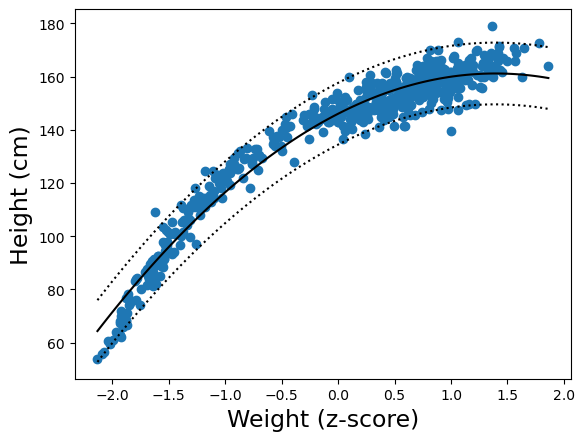

In [11]:
plt.scatter(kweights, kdata.height)
xnew = np.linspace(min(kweights),max(kweights),100)
y_ = b0.mean()+b1.mean()*xnew+b2.mean()*xnew**2
y_uu = y_+sig.mean()*2
y_ul = y_-sig.mean()*2
plt.plot(xnew, y_, c='black')
plt.plot(xnew, y_uu, ":", c='black')
plt.plot(xnew, y_ul, ":", c='black')
plt.xlabel('Weight (z-score)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('2ndorder.jpg', dpi=300);

Another way of plotting the intervals is to to make random draws from the posterior distribution, which contains a multitude of wiggly lines

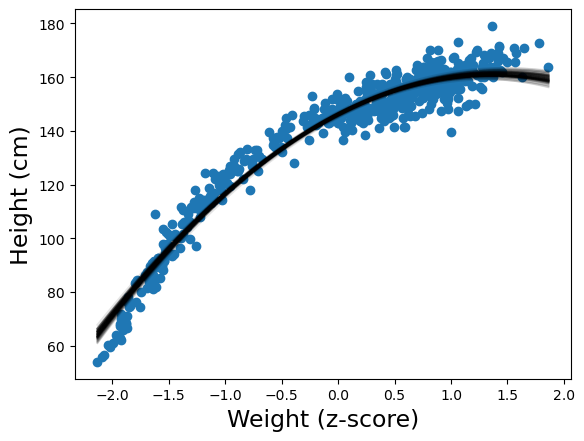

In [12]:
plt.scatter(kweights, kdata.height.values)
xnew = np.linspace(min(kweights),max(kweights),100)
for i in range(100):
    b0_ = np.random.choice(b0)
    b1_ = np.random.choice(b1)
    b2_ = np.random.choice(b2)
    y_ = b0_+b1_*xnew+b2_*xnew**2
    plt.plot(xnew, y_, c='black', alpha=0.1)
plt.xlabel('Weight (z-score)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17);

A key part of polynomials is that they often do a horrific job outside of the data, flopping around everywhere. This is clear if we look at slightly heavier people

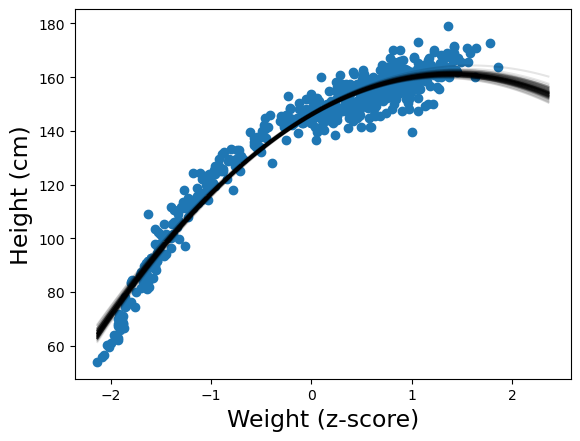

In [13]:
plt.scatter(kweights, kdata.height.values)
xnew = np.linspace(min(kweights),max(kweights)+0.5,100)
for i in range(100):
    b0_ = np.random.choice(b0)
    b1_ = np.random.choice(b1)
    b2_ = np.random.choice(b2)
    y_ = b0_+b1_*xnew+b2_*xnew**2
    plt.plot(xnew, y_, c='black', alpha=0.1)
plt.xlabel('Weight (z-score)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('fat2ndorder.jpg', dpi=300);

(shrinking large people...)

What about 3rd order?

In [14]:
# Model in PyMC
with pm.Model() as kung3:
    # Priors
    β0 = pm.Normal('Average_height', 178, 20)
    β1 = pm.Lognormal('Weight', 0, 1)
    β2 = pm.Normal('Weight2', 0, 1)
    β3 = pm.Normal('Weight3', 0, 1)
    σ = pm.Uniform('Obs_sd', 0, 50)
    
    # Linear model
    μ = β0+β1*kweights+β2*kweights**2+β3*kweights**3
    
    # Likelihood
    yi = pm.Normal('yi',μ, σ, observed=kdata.height.values)

In [15]:
# Sampling
with kung3:
    trace_p3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Average_height, Weight, Weight2, Weight3, Obs_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [16]:
b0 = trace_p3.posterior.Average_height.values.flatten()
b1 = trace_p3.posterior.Weight.values.flatten()
b2 = trace_p3.posterior.Weight2.values.flatten()
b3 = trace_p3.posterior.Weight3.values.flatten()
sig = trace_p3.posterior.Obs_sd.values.flatten()

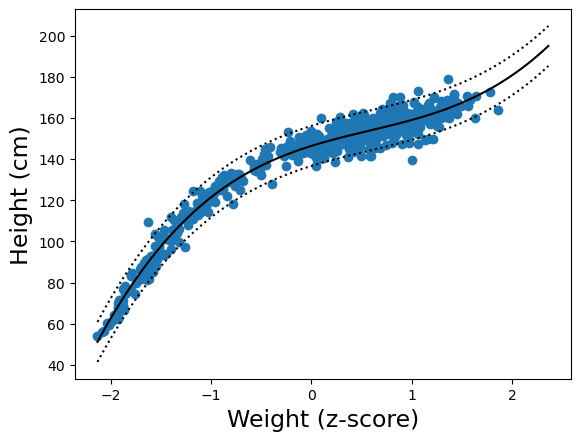

In [17]:
plt.scatter(kweights, kdata.height)
y_ = y_ = b0.mean()+b1.mean()*xnew+b2.mean()*xnew**2+b3.mean()*xnew**3
y_uu = y_+sig.mean()*2
y_ul = y_-sig.mean()*2
plt.plot(xnew, y_, c='black')
plt.plot(xnew, y_uu, ":", c='black')
plt.plot(xnew, y_ul, ":", c='black')
plt.xlabel('Weight (z-score)', fontsize=17)
plt.ylabel('Height (cm)', fontsize=17)
plt.savefig('3rdorder.jpg', dpi=300);

# Splines

![](splines.png)


 - Basis-Splines: wiggly function build from many local less wiggly functions
 - Basis function: a local function
 - Better than polynomials, but equally geocentric
 - Bayesian B-splines called *P-splines*
 
So what does these B-splines look like? Well they're just linear models that have synthetic variables (B's):

$$
\mu_i = \beta_0 + w_1 B_{i,1}+ w_2 B_{i,2}+...++ w_n B_{i,n}
$$

w - are weights that are just like slopes, while the basis functions turn on these weights for specific regions of *x*. 

To make this clear, let's have a look at the Japanese cherry blossom data:




In [18]:
cdata = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/cherry_blossoms.csv',sep=";")
tmp,tmp2 = sum(cdata.temp.isna()),len(cdata.temp)
# Drop rows where temp is NA
cdata = cdata[~cdata.temp.isna()]
cdata.head()

,year,doy,temp,temp_upper,temp_lower
38,839,NaN,5.87,10.99,0.75
39,840,NaN,5.99,10.78,1.21
40,841,NaN,6.12,10.60,1.64
41,842,NaN,6.25,10.47,2.02
42,843,NaN,6.37,10.39,2.35


In [19]:
tmp,tmp2, cdata.shape

(91, 1215, (1124, 5))

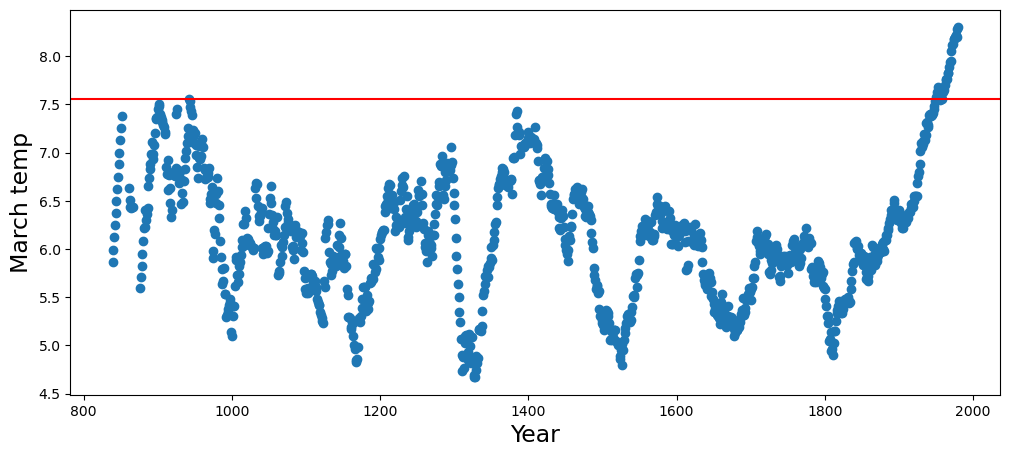

In [20]:
plt.figure(figsize=(12,5))
plt.scatter(cdata.year, cdata.temp)
plt.axhline(max(cdata.temp.values[cdata.year.values<1800]),c='red')
plt.xlabel('Year', fontsize=17)
plt.ylabel('March temp', fontsize=17)
plt.savefig('blossoms.jpg', dpi=300);

In [21]:
# Table of descriptive statistics
cdata.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1124.0,1418.243772,325.058651,839.00,1137.75,1418.500,1699.2500,1980.00
doy,787.0,104.921220,6.257730,86.00,101.00,105.000,109.0000,124.00
temp,1124.0,6.141886,0.663648,4.67,5.70,6.100,6.5300,8.30
temp_upper,1124.0,7.185151,0.992921,5.45,6.48,7.040,7.7200,12.10
temp_lower,1124.0,5.098941,0.850350,0.75,4.61,5.145,5.5425,7.74


So if we're going to put splines through this, how do they work? Well the algorithm needs to:

 - choose knots (places where the spline is anchored)
 - choose degree of basis functions (how wiggly)
 - find posterior distribution of the weights
 
So to start, let's pick some arbitrary knots across equal quantiles across the data:

In [22]:
# Number of knots
nk = 5
# Knot locations
naughts = np.quantile(cdata.year, q=np.linspace(0,1, num=nk))
naughts

array([ 839.  , 1137.75, 1418.5 , 1699.25, 1980.  ])

So how do we chose the degree of basis functions?

Well, can start with basis fucntions which are degree 1, which make them a linear combination at 2 points:

![](basis1.jpg)

To get our basis functions, we can use the `dmatrix` function in `patsy`:

In [23]:
# Construct the Basis function matrix: https://patsy.readthedocs.io/en/latest/spline-regression.html#general-b-splines
B = patsy.dmatrix("bs(year, knots=knots, degree=1, include_intercept=True)",
                   data={'year': cdata.year.values,
                         'knots': naughts[1:-1]})
# Construct the Basis function matrix: https://patsy.readthedocs.io/en/latest/spline-regression.html#general-b-splines
B2 = patsy.dmatrix("bs(year, knots=knots, degree=2, include_intercept=True)",
                   data={'year': cdata.year.values,
                         'knots': naughts[1:-1]})

In [24]:
np.asarray(B)

array([[1.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.99665272, 0.00334728, 0.        , 0.        ,
        0.        ],
       [1.        , 0.99330544, 0.00669456, 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , 0.        , 0.00712378,
        0.99287622],
       [1.        , 0.        , 0.        , 0.        , 0.00356189,
        0.99643811],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ]])

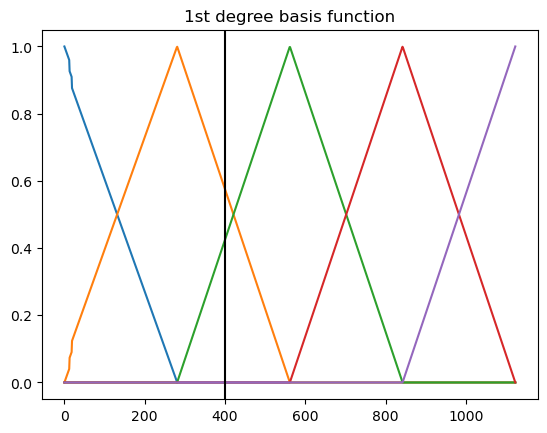

In [25]:
[plt.plot(b) for b in B.T[1:]]
plt.title('1st degree basis function')
plt.axvline(400,c='black')
plt.savefig('basis_fun.jpg', dpi=300);

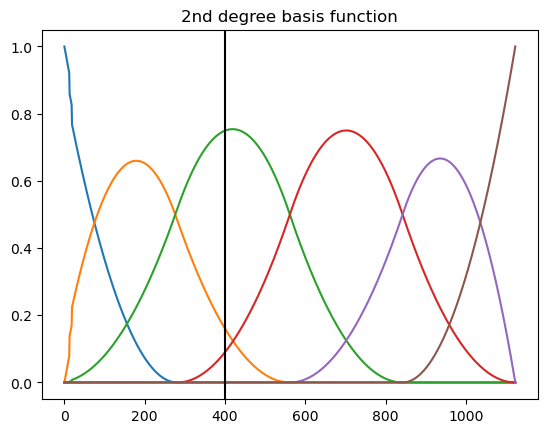

In [26]:
[plt.plot(b) for b in B2.T[1:]]
plt.title('2nd degree basis function')
plt.axvline(400,c='black')
plt.savefig('basis_fun2.jpg', dpi=300);

The werid thing about this is that it is just a linear model, which we can calculate in PyMC:

In [27]:
# Model PyMC
with pm.Model() as temps:
    # Priors
    b0 = pm.Normal('b0', 6, 10)
    w = pm.Normal('w', 0, 1, shape=B.shape[1])
    mu = pm.Deterministic('mu', b0 + pm.math.dot(np.asarray(B), w.T))
    sigma = pm.Exponential('sigma', 1)
    T = pm.Normal('T', mu, sigma, observed=cdata.temp.values)


In [28]:
# Sampling
with temps:
    trace_t = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Looking back at our equation:

$$
\mu_i = \beta_0 + w_1 B_{i,1}+ w_2 B_{i,2}+...++ w_n B_{i,n}
$$

we 'simply' need to add these all together

In [29]:
# Grab the posterior means
b0 = trace_t.posterior.b0.values.mean()
w = trace_t.posterior.w.values.mean(1)

In [30]:
w

array([[-0.05755534,  0.68769527, -0.57350981,  0.1827682 , -0.96797469,
         0.85441585],
       [ 0.08418447,  0.66390924, -0.59569052,  0.16174229, -0.99050847,
         0.83227866],
       [ 0.02813658,  0.63136971, -0.62632002,  0.12895441, -1.02188242,
         0.7987408 ],
       [-0.0157851 ,  0.64745459, -0.60888586,  0.14388476, -1.00642298,
         0.81515367]])

In [31]:
# Solve for mean spline value at each observation
spline_ = np.array([np.mean(x) for x in b0+np.dot(np.asarray(B), w.T)])

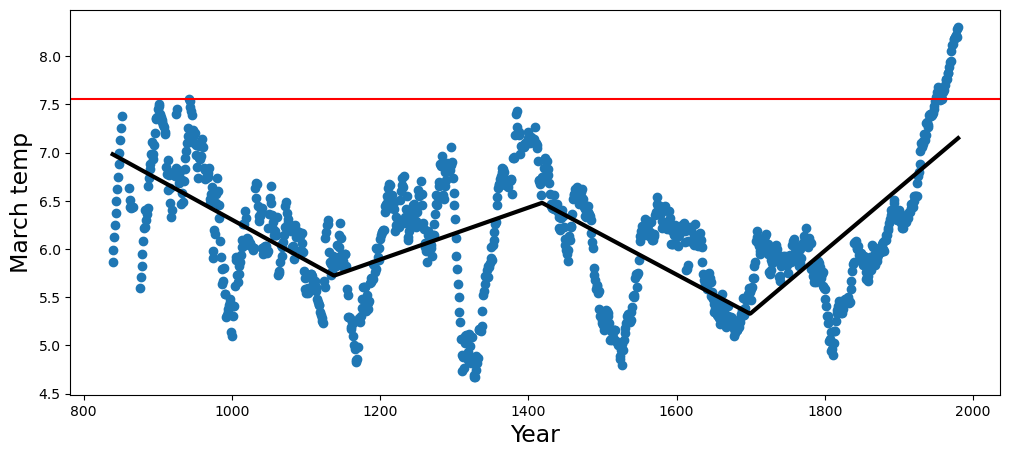

In [32]:
plt.figure(figsize=(12,5))
plt.scatter(cdata.year, cdata.temp)
plt.plot(cdata.year, spline_, c='black', linewidth=3)
plt.axhline(max(cdata.temp.values[cdata.year.values<1800]),c='red')
plt.xlabel('Year', fontsize=17)
plt.ylabel('March temp', fontsize=17)
plt.savefig('blossom_spline.jpg', dpi=300);

Let's take a look at 2nd order

In [33]:
# Model in PyMC
with pm.Model() as temps2:
    # Priors
    b0 = pm.Normal('b0', 6, 10)
    w = pm.Normal('w', 0, 1, shape=B2.shape[1])
    mu = pm.Deterministic('mu', b0 + pm.math.dot(np.asarray(B2), w.T))
    sigma = pm.Exponential('sigma', 1)
    T = pm.Normal('T', mu, sigma, observed=cdata.temp.values)

In [34]:
# Sampling
with temps2:
    trace_t2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [35]:
# Grab the posterior means
b0 = trace_t2.posterior.b0.values.mean()
w = trace_t2.posterior.w.values.mean(1)

In [36]:
# Solve for mean spline value at each observation
spline_ = np.array([np.mean(x) for x in b0+np.dot(np.asarray(B2), w.T)])

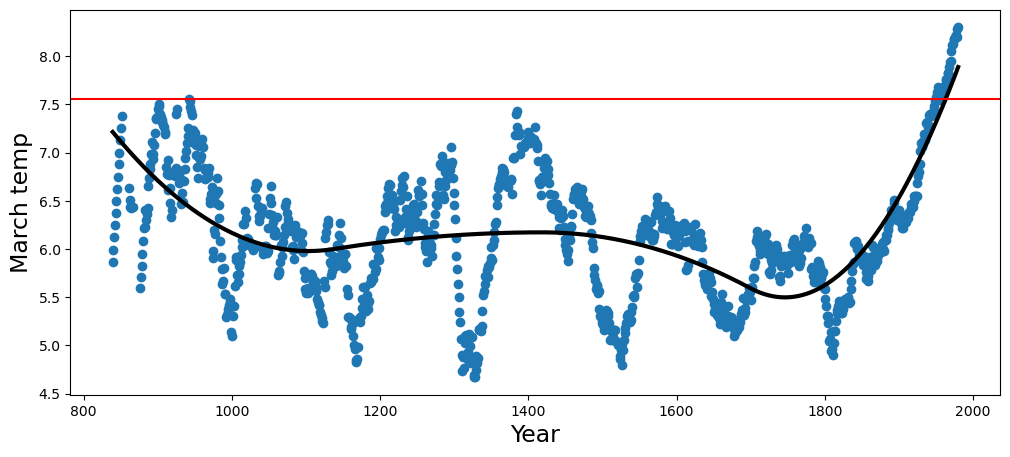

In [37]:
plt.figure(figsize=(12,5))
plt.scatter(cdata.year, cdata.temp)
plt.plot(cdata.year, spline_, c='black', linewidth=3)
plt.axhline(max(cdata.temp.values[cdata.year.values<1800]),c='red')
plt.xlabel('Year', fontsize=17)
plt.ylabel('March temp', fontsize=17)
plt.savefig('blossom_spline2.jpg', dpi=300);